In [10]:
import os
import sys
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import zarr

# Import delay and parallel functions from joblib
from joblib import delayed, Parallel

import histomicstk

from histomicstk.preprocessing.color_conversion import rgb_to_lab, lab_mean_std, rgb_to_hsi
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask, threshold_multichannel)

OPENSLIDE_PATH = r"C:\Users\borgh\openslide-bin-4.0.0.6-windows-x64\bin" # Change to the path where you extracted the OpenSlide binaries

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
        import openslide.deepzoom
else:
    import openslide

vipsHome = r"C:\Users\borgh\vips-dev-8.16\bin" # Change to the path where you extracted the VIPS binaries
os.environ['PATH'] = vipsHome + ';' + os.environ['PATH']
import pyvips

sys.path.append(r"C:\Users\borgh\OneDrive\Dokumenter\UIB\Master\Annotering\Bilder\Make_patches\utils") # Change to the path where you cloned the repository
import GenericTiffHandler.GenericTiffHandlerV3 as genTiff

In [8]:
def get_white_mask(img):
    # Create a mask with all white (background) pixels labeled as 1
    white_mask, _ = threshold_multichannel(rgb_to_hsi(img), {
        'hue': {'min': 0, 'max': 1.0},
        'saturation': {'min': 0, 'max': 0.2},
        'intensity': {'min': 220, 'max': 255},
    },just_threshold=True)

    return white_mask

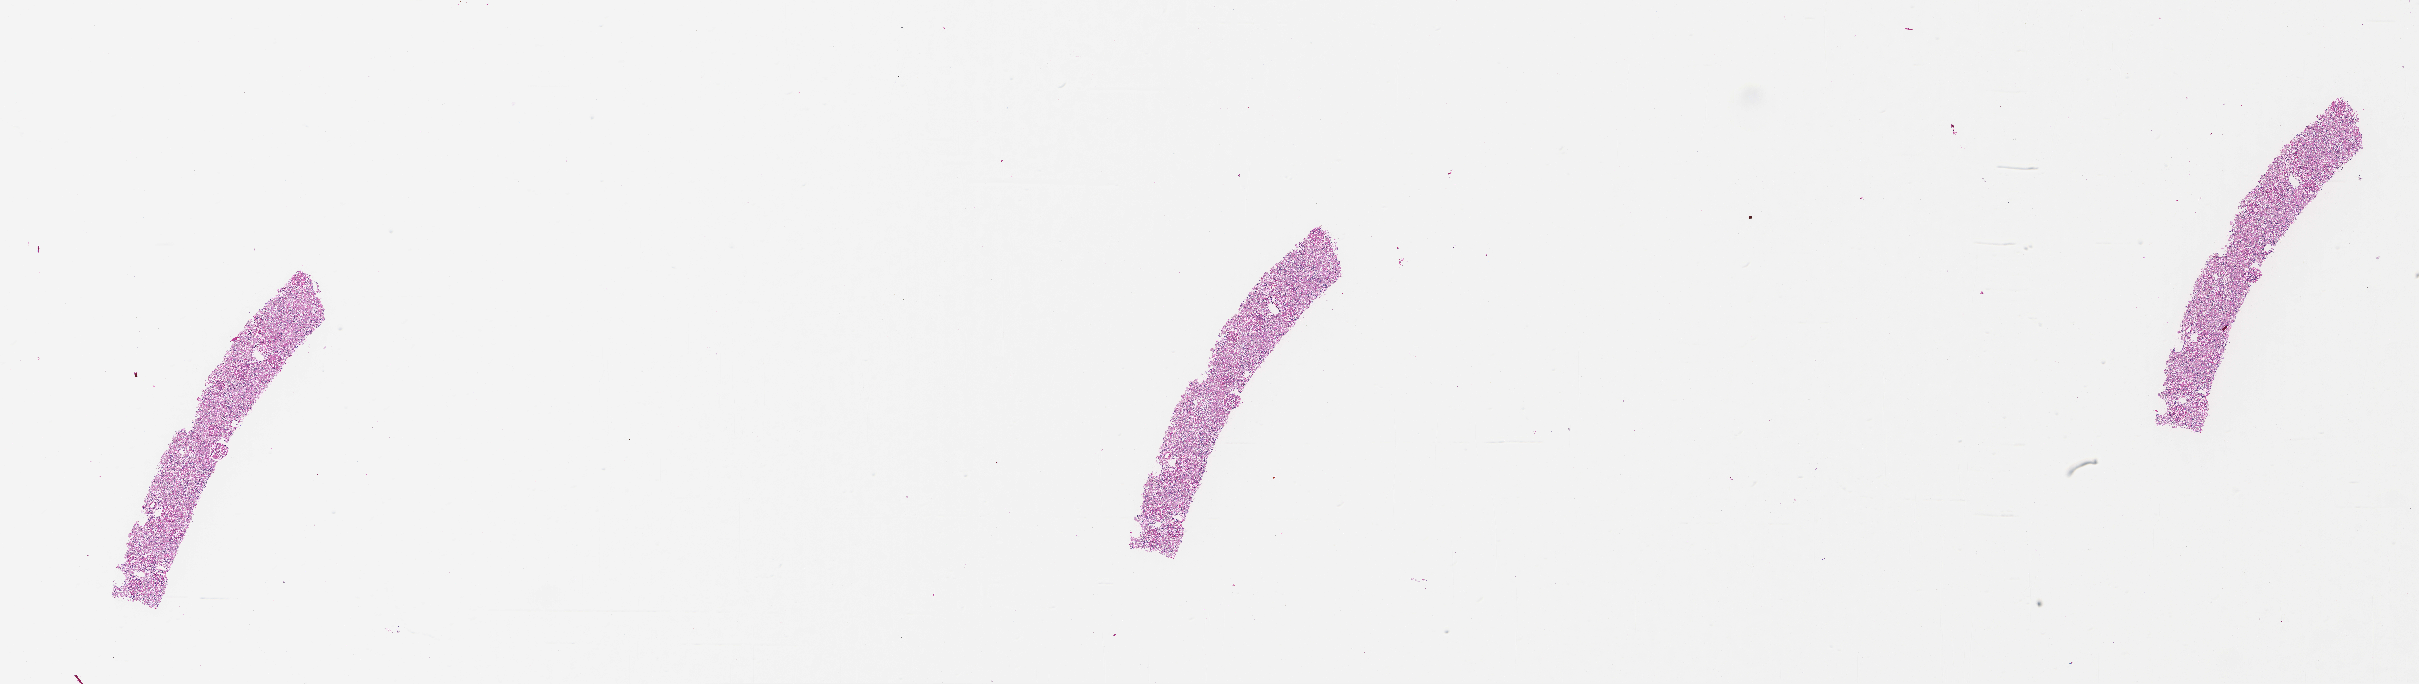

In [22]:
# Load the slide
slide_path = r"C:\Users\borgh\OneDrive\Dokumenter\UIB\Master\Annotering\Bilder\Train-QA\borg2022_000000_ANON.svs"
slide = genTiff.GenericTiffHandler(slide_path)

# Display a thumbnail for sanity check
display(slide.get_thumbnail(50))

In [31]:
import os
lst = os.listdir(r"C:\Users\borgh\OneDrive\Dokumenter\UIB\Master\Annotering\Bilder\Train-QA")
for i in range(len(lst)):
    lst[i] = lst[i].split(".")[0]
    print(lst[i])

borg2022_000000_ANON
borg2022_000001_ANON
borg2022_000002_ANON
borg2022_000003_ANON
borg2022_000006_ANON
Patient1_2012_PAS_ANON
Patient2_2014_PAS_ANON
Patient5_2016_PAS_ANON


In [34]:
#nums = ["2022_000000"]

for num in lst:
    slide_path = r"C:\Users\borgh\OneDrive\Dokumenter\UIB\Master\Annotering\Bilder\Train-QA\\"+num+".svs"
    slide = genTiff.GenericTiffHandler(slide_path)

    tissue_mask = r"C:\Users\borgh\OneDrive\Dokumenter\UIB\Master\Annotering\Bilder\Make_patches\Tissue_masks\\"+num+".tiff"# Pass the tissue mask path here if you have one (I recommend)

    #if tissue_mask is not None:
    #    tissue_mask = genTiff.GenericTiffHandler(path=tissue_mask)

    # Define the parameters for the patch extraction
    tile_size = 2048
    overlap = 0
    tissue_percentage = 50

    # Given these parameters, we can calculate the number of tiles in each dimension
    tiles_y,tiles_x = slide.get_tile_dimensions(tile_size, tile_size, overlap)
    print((tiles_y),(tiles_x))


    # Using parallel processing, we can extract all the patches in parallel that contain tissue
    def is_tile_valid(tissue_percentage,slide_path, tissue_mask, tile_size, overlap, col, row):
        
        if tissue_mask is not None:
            tissue_mask = genTiff.GenericTiffHandler(tissue_mask)
            tissue_tile = np.asarray(tissue_mask.get_tile(tile_size,tile_size,overlap,col,row))
            if np.max(tissue_tile) > 1:
                tissue_tile = tissue_tile/255
            if (np.sum(tissue_tile)/(tile_size*tile_size))*100 >= tissue_percentage:
                return col,row
            else:
                return None
        else:
            slide = genTiff.GenericTiffHandler(slide_path)
            tile = np.asarray(slide.get_tile(tile_size,tile_size,overlap,col,row))
            background_mask = get_white_mask(tile)
            tissue_mask = np.logical_not(background_mask)
            
            if (np.sum(tissue_mask)/(tile_size*tile_size))*100 >= tissue_percentage:
                return col,row
            else:
                return None

    # If your computer is overworkded, you can reduce the number of jobs
    list_of_tiles = Parallel(n_jobs=2)(
        delayed(is_tile_valid)(
            tissue_percentage,slide_path, tissue_mask, tile_size, overlap, col, row) for col in range(tiles_y) for row in range(tiles_x))
            
    list_of_tiles = [tile for tile in list_of_tiles if tile is not None]

    print(f"Number of tiles with % of tissue > {tissue_percentage} %: {len(list_of_tiles)}")

    # Define the output path
    output_path = r"C:\Users\borgh\OneDrive\Dokumenter\UIB\Master\Annotering\Bilder\Make_patches\output\\"+num

    def extract_tile(output_path,slide_path, tile_size, overlap, col, row):
        tile = genTiff.GenericTiffHandler(slide_path).get_tile(tile_size,tile_size,overlap,col,row)
        try:
            tile.save(output_path + f"\\{num}_{col}_{row}.png")
            return True
        except:
            return None

    # Extract the tiles
    # If your computer is overworkded, you can reduce the number of jobs
    saving = Parallel(n_jobs=8)(
        delayed(extract_tile)(
            output_path,slide_path, tile_size, overlap, col, row) for col,row in list_of_tiles)

    saving = [save for save in saving if save is not None]

    print(f"Number of tiles saved: {len(saving)}")

60 17
Number of tiles with % of tissue > 50 %: 10
Number of tiles saved: 10
74 24
Number of tiles with % of tissue > 50 %: 14
Number of tiles saved: 14
53 13
Number of tiles with % of tissue > 50 %: 3
Number of tiles saved: 3
67 18
Number of tiles with % of tissue > 50 %: 12
Number of tiles saved: 12
64 25
Number of tiles with % of tissue > 50 %: 11
Number of tiles saved: 11
24 18
Number of tiles with % of tissue > 50 %: 10
Number of tiles saved: 10
24 37
Number of tiles with % of tissue > 50 %: 10
Number of tiles saved: 10
43 30
Number of tiles with % of tissue > 50 %: 35
Number of tiles saved: 35
